In [1]:
%matplotlib widget

from pathlib import Path
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("matplotlib_style.txt")

import numpy as np
import pandas as pd

np.random.seed(42)

import sklearn
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import scipy
from scipy.spatial.distance import pdist

from openTSNE import TSNE
from rnanorm import CTF  # pip install rnanorm
from umap import UMAP

c:\Users\j1559\anaconda3\envs\nds_env\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\j1559\anaconda3\envs\nds_env\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\j1559\anaconda3\envs\nds_env\lib\site-packages\umap\distances.py:1086: NumbaD

In [2]:
import plots, utils

In [3]:
import jupyter_black
jupyter_black.load(line_length=79)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

In [4]:
data_path = Path("../data")

## Import

### Meta data

In [5]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

**Exon counts**

In [6]:
data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
assert all(cells == data_exons.columns)

genes = data_exons.index
exonCounts = data_exons.transpose()

print("Count matrix shape (exon):  ", exonCounts.shape)
exonCounts.head()

Count matrix shape (exon):   (1329, 42466)


0610005C13Rik  0610006L08Rik  0610009B22Rik  0610009E02Rik   
20171204_sample_2              0              0              0              0  \
20171204_sample_4              0              0             68              0   
20171204_sample_5              0              0           1291              0   
20171204_sample_6              0              0              0              0   
20171207_sample_1              0              0              0             30   

                   0610009L18Rik  0610010F05Rik  0610012D04Rik  0610012G03Rik   
20171204_sample_2              0           1478              0              0  \
20171204_sample_4              0              8              0              0   
20171204_sample_5              0           1562              0           2381   
20171204_sample_6              0            581              0              0   
20171207_sample_1              0             62              0             79   

                   0610025J13Rik  0610030E20Rik  ...  n-R5s82  n-R5s84   
20171204_sample_2              0              0  ...        0        0  \
20171204_sample_4              0             29  ...        0        0   
20171204_sample_5              0              0  ...        0        0   
20171204_sample_6              0              0  ...        0        0   
20171207_sample_1              0            277  ...        0        0   

                   n-R5s85  n-R5s86  n-R5s88  n-R5s96  n-R5s97  n-R5s98   
20171204_sample_2        0        0        0        0        0        0  \
20171204_sample_4        0        0        0        0        0        0   
20171204_sample_5        0        0        0        0        0        0   
20171204_sample_6        0        0        0        0        0        0   
20171207_sample_1        0        0        0        0        0        0   

                   n-TSaga9  n-TStga1  
20171204_sample_2         0         0  
20171204_sample_4         0         0  
20171204_sample_5         0         0  
20171204_sample_6         0         0  
20171207_sample_1         0         0  

[5 rows x 42466 columns]

In [7]:
data_gene_len = pd.read_csv(data_path / "gene_lengths.txt", index_col=0)
assert all(data_gene_len.index == genes)

exonLengths = data_gene_len["exon_bp"]
exonLengths.head()

GeneID
0610005C13Rik    3583
0610006L08Rik    2128
0610009B22Rik     998
0610009E02Rik    1803
0610009L18Rik     619
Name: exon_bp, dtype: int64

### Cluster colors

In [8]:
cluster_colors = np.load(data_path / "cluster_colors.npy")

In [9]:
cluster_colors.shape

(1329,)

In [10]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)

In [11]:
rna_type.shape

(1329,)

In [12]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [13]:
len(dict_rna_type_colors)

88

### Electrophysiological features

In [14]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [15]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [16]:
np.sum(np.isnan(ephysData_filtered))

0

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    

## 1) Inspecting Data

In [17]:
# check for nan
assert not exonCounts.isna().any(axis=None)

In [18]:
# Kick out all genes with all counts = 0
genes = genes[exonCounts.sum(axis=0) > 0]
exonLengths = exonLengths[exonCounts.sum(axis=0) > 0]
exonCounts = exonCounts.loc[:, exonCounts.sum(axis=0) > 0]

# check if they keep same size
assert genes.size == exonCounts.shape[1]

In [19]:
# Compute the average expression for each gene
avg_counts = exonCounts.mean(axis=0)

# Compute the fraction of zeros for each gene
zero_fraction = np.sum(exonCounts == 0, axis=0) / exonCounts.shape[0]

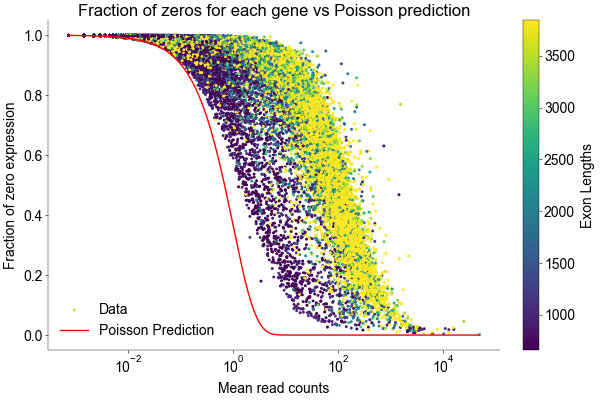

In [20]:
plots.plot_zero_fraction(
    avg_counts,
    zero_fraction,
    cmap="viridis",
    c=exonLengths,
    vmin=exonLengths.quantile(0.25),
    vmax=exonLengths.quantile(0.75),
)

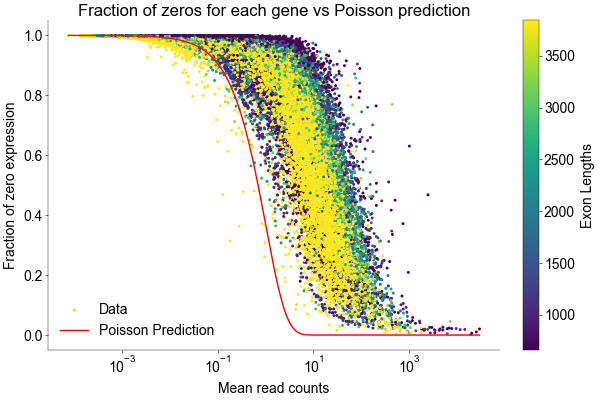

In [21]:
avg_counts_corrected = avg_counts / (exonLengths * 1e-3)

plots.plot_zero_fraction(
    avg_counts_corrected,
    zero_fraction,
    cmap="viridis",
    c=exonLengths,
    vmin=exonLengths.quantile(0.25),
    vmax=exonLengths.quantile(0.75),
)

Chen, W., Li, Y., Easton, J. et al. UMI-count modeling and differential expression analysis for single-cell RNA sequencing. Genome Biol 19, 70 (2018). https://doi.org/10.1186/s13059-018-1438-9

Jiang, R., Sun, T., Song, D. et al. Statistics or biology: the zero-inflation controversy about scRNA-seq data. Genome Biol 23, 31 (2022). https://doi.org/10.1186/s13059-022-02601-

Bacher, R., Chu, LF., Leng, N. et al. SCnorm: robust normalization of single-cell RNA-seq data. Nat Methods 14, 584–586 (2017). https://doi.org/10.1038/nmeth.4263

Johnson, K.A., Krishnan, A. Robust normalization and transformation techniques for constructing gene coexpression networks from RNA-seq data. Genome Biol 23, 1 (2022). https://doi.org/10.1186/s13059-021-02568-9


As we were expecting, the read counts seem to deviate significantly from the Poisson model. First observation is that the fraction of zeroes observed is consistently higher than a Poisson model would predict. Another one is a visually noticeable variability of the mean read counts for a same fraction of zeros, resulting in a wide curve (very different from what was observed in the dataset of CodingLab 7). As it is evident in the plot, this wider curve can partially be explained by the length of the exons, which introduces a bias in the counting (longer exons generate more slice). However, the normalized version only partially reduces the width of the scatter plot.
 One of the main factors underlying these deviances is probably the so-called amplification bias. Since the amount of transcripts collected from single cells is very small, cDNA amplification is necessary for the construction of the library. Nevertheless, this amplification is also a stochastic process, resulting in distortions (Chen et al. 2018). The UMI techniques try to mitigate this bias, by tagging the transcripts before amplification.

Another point raised by Chen et al. (2018) is the higher number of dropout events in single cell sequencing (missing values, due to biological and technical stochasticity). The authors argue that accounting for this kind of event is relevant for read counts, but not much for UMI. Apparently, there is a big discussion in the scRNA-seq field if models should include zero inflations (to correct for the dropout events) or not (Jiang et al. 2022). 


### Some statistics

In [22]:
depth = np.sum(exonCounts, axis=1)
genes_detected = np.sum(exonCounts != 0, axis=1)

# Basic statistics (same reported in GitHub https://github.com/berenslab/mini-atlas/blob/master/code/ttype-assignment.ipynb)
print(
    "Depth: median {:.0f}, mean+-STD log10: {:.1f}+-{:.1f}".format(
        np.median(depth), np.mean(np.log10(depth)), np.std(np.log10(depth))
    )
)
print(
    "Genes detected per cell: median {:.0f}, mean+-STD: {:.0f}+-{:.0f}".format(
        np.median(genes_detected),
        np.mean(genes_detected),
        np.std(genes_detected),
    )
)

Depth: median 1281492, mean+-STD log10: 6.0+-0.6
Genes detected per cell: median 6897, mean+-STD: 6766+-2742


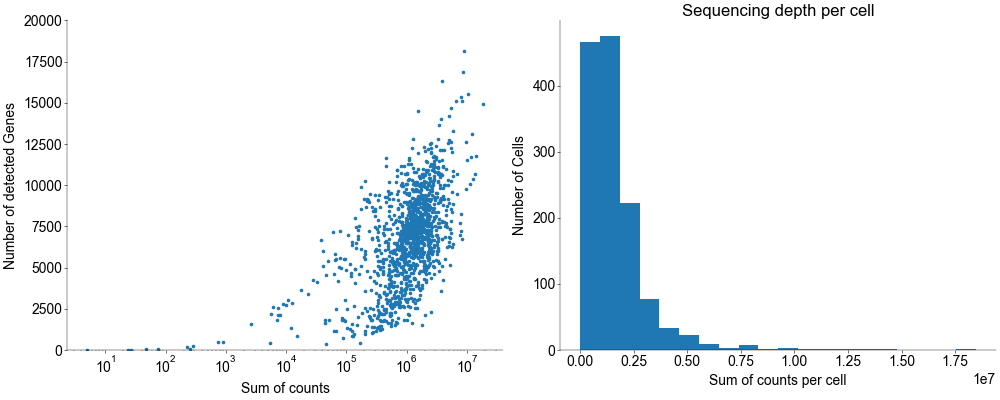

In [23]:
plots.plot_depth_per_cell(depth, genes_detected)

#### Mean-Variance analysis 

Although we know that the counts should not be Poisson distributed, we plot here the mean vs variance analysis, as well the Fano factor compared to a Poisson. We can clearly observe that the variance increases faster than the mean. This overdispersion could have been modeled by a negative binomial

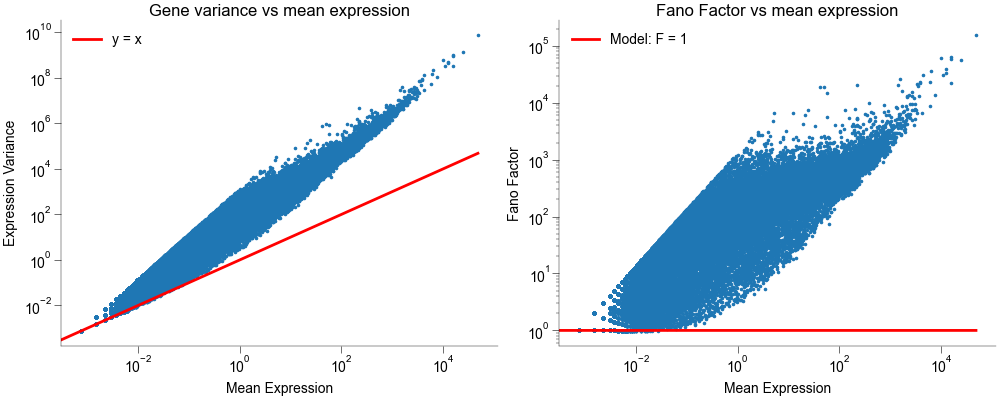

In [24]:
plots.plot_fano_factor(exonCounts)

## Normalization and Transformation

In this study case, we want to perform a between-samples comparison from data coming from scRNA-seq. According to https://www.reneshbedre.com/blog/expression_units.html?utm_content=cmp-true , an adequate normalization for this case would be the SCnorm, proposed by Bacher et al. 2017. However, we didn’t find a python implementation. Thus, we decided to use CTF normalization (which is a variation of TMM) and is supposed to be a robust method for between-sample comparisons (Johnson, Krishnan 2022), although more suitable for bulk sequencing. Interestingly, looking at the code provided in the GitHub of the original paper (Scala et al 2021), it seems that the authors opted for a gene-length normalization, which doesn’t account for the difference in depth of the samples. This kind of normalization is generally recommended for within-sample comparisons, what is not the case here. We could see before that it indeed plays a role in how the average counts and fractions of zeroes are related, but it is not straight forward how this would be decisive in a between samples comparison.
Therefore, we decided to also add it here, so we can compare the effect of these two different normalizations.

### CTF normalization


In [25]:
print(exonCounts.shape)
CTF_exon_counts = (
    CTF().set_output(transform="pandas").fit_transform(exonCounts)
)

(1329, 42197)


c:\Users\j1559\anaconda3\envs\nds_env\lib\site-packages\rnanorm\methods\between_sample.py:93: RuntimeWarning: divide by zero encountered in divide
  return factors / self.geometric_mean_
c:\Users\j1559\anaconda3\envs\nds_env\lib\site-packages\rnanorm\methods\between_sample.py:93: RuntimeWarning: invalid value encountered in divide
  return factors / self.geometric_mean_


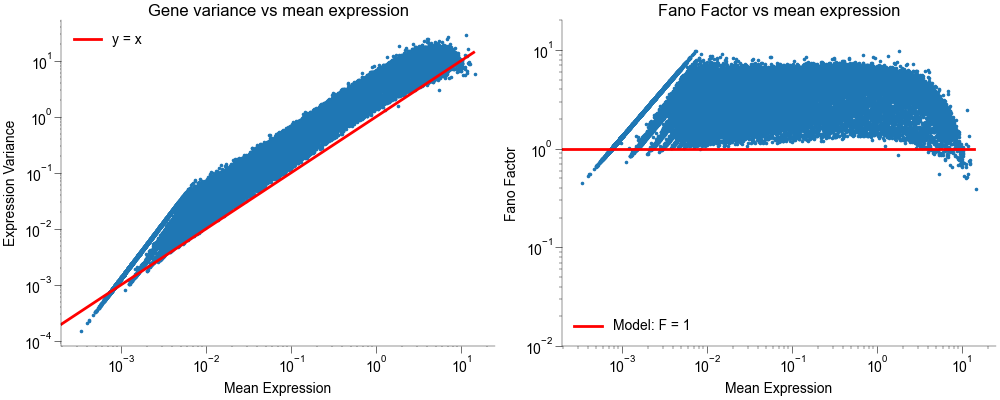

In [26]:
log_CTF_exon_counts = np.log2(CTF_exon_counts + 1)

plots.plot_fano_factor(log_CTF_exon_counts, ylim=(0.01, 20))

In GitHub of original paper, it seems that the normalization applied was: counts / (exonLenght / 1000). So we will also use this one for comparison.



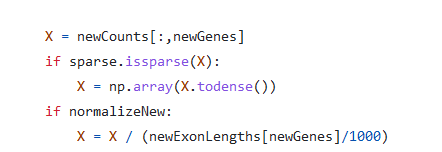

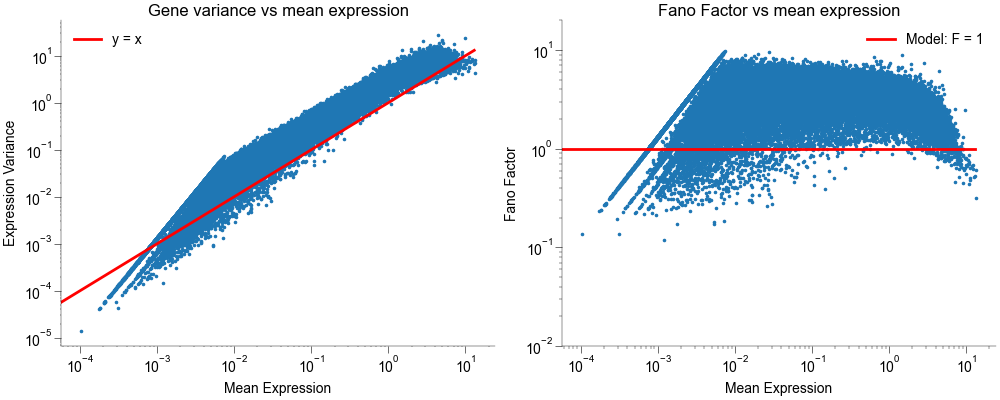

In [27]:
norm_counts = exonCounts / (exonLengths / 1000)
log_norm_counts = np.log2(norm_counts + 1)

plots.plot_fano_factor(log_norm_counts, ylim=(0.01, 20))

### PCA visualization for different transformations and normalization

**Gene selection strategies**

After both normalizations and log transform, the Fano factor of the data looks apparently independent of the mean expression for the gene. Thus, we now can try to use the Fano factor as a criterion to select the genes with most variability with respect to their means (basically what was done in CodingLab 7). However, it is not clear what should be the selection threshold. Here, we basically tried different values and observed the behavior of the PCA plot. This method is of course not ideal, since we had the benefit of knowing the true labels, which is not the case for many of the practical situations. The procedure was repeated for both normalizations.

Resourcing to the original paper, the gene selection was performed using the mean-dropout relatioship technique described in Kobak, Berens (2019). The near zero frequency expressions for a gene (counts up to a threshold of 32 counts were considered to be 0) was modeled as a function of the mean log2 nonzero expression for the same gene (the mean of the log2 counts considering only cells which expressed the gene). The used model was a decaying exponential with a fixed decay rate (1.5) and y-offset (0.02). The x-offset was used then to select the desired number of genes. The selected genes were the ones with a higher fraction of zeroes then the expected by the model given the mean log2 nonzero expression. Intuitively, this procedure selects genes that are not expressed at all in some cells, but strongly expressed by others. It is reasonable to assume that those genes could be markers to differentiate between cells. The value of the decay rate and threshold were found heuristically and with use of previous knowledge (authors cite that genes known to be marker were being left out for threshold = 0).


Chosen offset: 7.64


c:\Users\j1559\Documents\Tuebingen\SS_23\Neural_Data_Science\neural-data-science-project\notebooks\utils.py:136: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


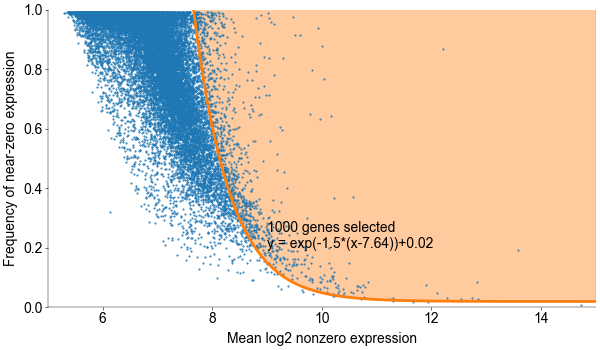

1000


In [28]:
## Dropout gene selection
dropout_gene_selection = utils.geneSelection(
    exonCounts, n=1000, threshold=32, decay=1.5, yoffset=0.02
)
print(np.sum(dropout_gene_selection))

In [29]:
## Fano gene selection

fano = utils.compute_fano_factor(log_CTF_exon_counts)
fano_selection = fano > 6
print(np.sum(fano_selection))

fano = utils.compute_fano_factor(log_norm_counts)
fano_selection = fano > 6
print(np.sum(fano_selection))

2198
1662


**Transformations**


We plotted here, as an example, the first 2 PCs for the CTF example using: no transformation, log2(x+1) and sqrt. The genes were selecting use the Fano factor criteria. We can see that the log2 transformation resulted in a better separation already in the PCA, so we decided to keep it.  This was similar for the exon length normalization, and also for both normalizations using the features selected by the mean-dropout relationship.

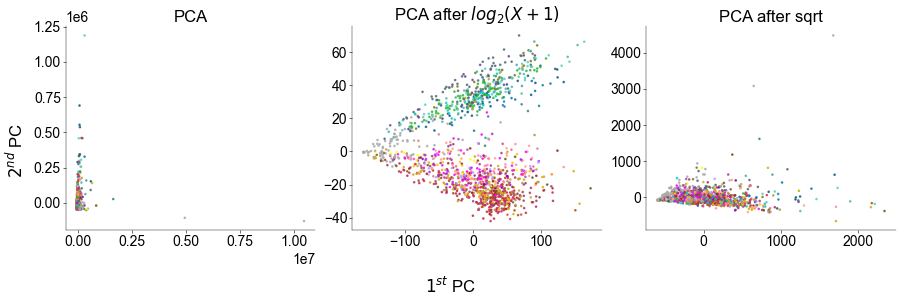

In [30]:
## Standard, log2, and sqrt transformations

pca = PCA(n_components=50)
pca_ctf = [
    pca.fit_transform(counts.loc[:, dropout_gene_selection])
    for counts in (
        CTF_exon_counts,
        np.log2(CTF_exon_counts + 1),
        np.sqrt(CTF_exon_counts),
    )
]

plots.plot_PCA_row(
    pca_ctf,
    ["PCA", "PCA after $log_2(X+1)$", "PCA after sqrt"],
    cluster_colors,
)

**Selection/normalization pairs**

In the plot, we can see that all the combinations show a separation of two clusters: excitatory cells and interneurons. The gray cells are cells that could not be assigned to any type by the authors. Surprisingly, for the exon length normalization with genes selected using the Fano factor, we can actually see the separation in three clusters: the excitatory and the 2 major transcriptomics categories of interneurons. However, this doesn’t necessarily implies that these are the best features for representing the data in lower dimensions.

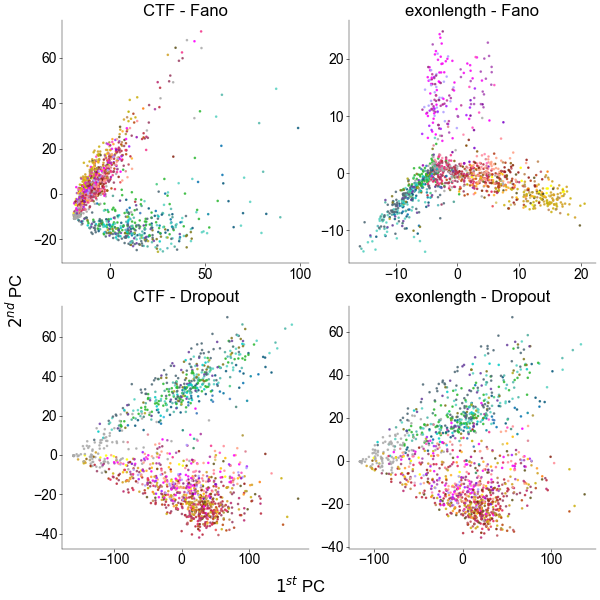

In [31]:
fano_selection_func = lambda c: utils.compute_fano_factor(c) > 6
dropout_selection_func = lambda _: dropout_gene_selection

pca_grid = utils.make_pca_grid(
    [fano_selection_func, dropout_selection_func],
    [log_CTF_exon_counts, log_norm_counts],
)
plots.plot_PCA_grid(
    pca_grid,
    ["Fano", "Dropout"],
    ["CTF", "exonlength"],
    cluster_colors,
)

**TSNE**

Although the PCA for the pair (exon length - Fano) seems to be the generating the better separation, this didn't translated to the same result for the tsne. To avoid plotting to many figures, we decide to continue here only with the CTF normalized counts with genes selected by the dropout-mean relationship, since it presented the best metrics.

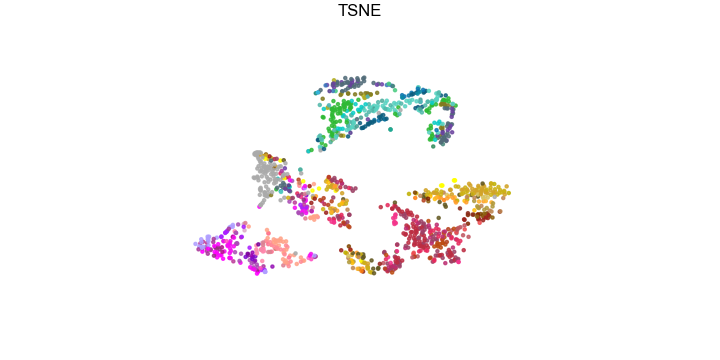

In [32]:
pca_result = pca.fit_transform(
    log_CTF_exon_counts.loc[:, dropout_selection_func(log_norm_counts)]
)

tsne = TSNE(perplexity=30, random_state=42)
tsne_counts = tsne.fit(pca_result)

s = 80
plots.plot_TSNE(tsne_counts, cluster_colors, [[-s, s], [-s, s]])

In [33]:
# function adapted from https://github.com/berenslab/rna-seq-tsne/blob

def embedding_quality(X, Z, knn=10, subsetsize=1000):
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / X.shape[0] / knn

    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset, :])
    d2 = pdist(Z[subset, :])
    rho = scipy.stats.spearmanr(d1[:, None], d2[:, None]).correlation

    return (mnn, rho)

In [34]:
def plot_tSNE_grid(perplex_vals, exag_vals, data, cluster_colors):
    fig, axs = plt.subplots(
        len(perplex_vals),
        len(exag_vals),
        figsize=(2 * len(exag_vals), 2 * len(perplex_vals)),
    )

    metrics = []
    for ax_row, perplex in zip(axs, perplex_vals):
        for ax, exag in zip(ax_row, exag_vals):
            tsne = TSNE(perplexity=perplex, exaggeration=exag, random_state=42)
            tsne_counts = tsne.fit(data)

            # Log metrics
            metrics.append(embedding_quality(data, tsne_counts))

            print(
                f"Perplexity: {perplex},\tExaggeration: {exag},\tEmbedding Quality: ({metrics[-1][0]:.3f}, {metrics[-1][1]:.3f})"
            )

            plots.plot_TSNE(tsne_counts, cluster_colors, ax=ax)

    return metrics

Perplexity: 5.0,	Exaggeration: 0.9,	Embedding Quality: (0.511, 0.502)
Perplexity: 5.0,	Exaggeration: 0.9333333333333333,	Embedding Quality: (0.512, 0.498)
Perplexity: 5.0,	Exaggeration: 0.9666666666666667,	Embedding Quality: (0.509, 0.490)
Perplexity: 5.0,	Exaggeration: 1.0,	Embedding Quality: (0.511, 0.510)
Perplexity: 5.0,	Exaggeration: 1.0333333333333332,	Embedding Quality: (0.513, 0.497)
Perplexity: 5.0,	Exaggeration: 1.0666666666666667,	Embedding Quality: (0.513, 0.503)
Perplexity: 5.0,	Exaggeration: 1.1,	Embedding Quality: (0.511, 0.513)
Perplexity: 5.0,	Exaggeration: 1.1333333333333333,	Embedding Quality: (0.512, 0.502)
Perplexity: 5.0,	Exaggeration: 1.1666666666666665,	Embedding Quality: (0.513, 0.505)
Perplexity: 5.0,	Exaggeration: 1.2,	Embedding Quality: (0.513, 0.510)
Perplexity: 6.666666666666667,	Exaggeration: 0.9,	Embedding Quality: (0.526, 0.417)
Perplexity: 6.666666666666667,	Exaggeration: 0.9333333333333333,	Embedding Quality: (0.525, 0.416)
Perplexity: 6.6666666666666

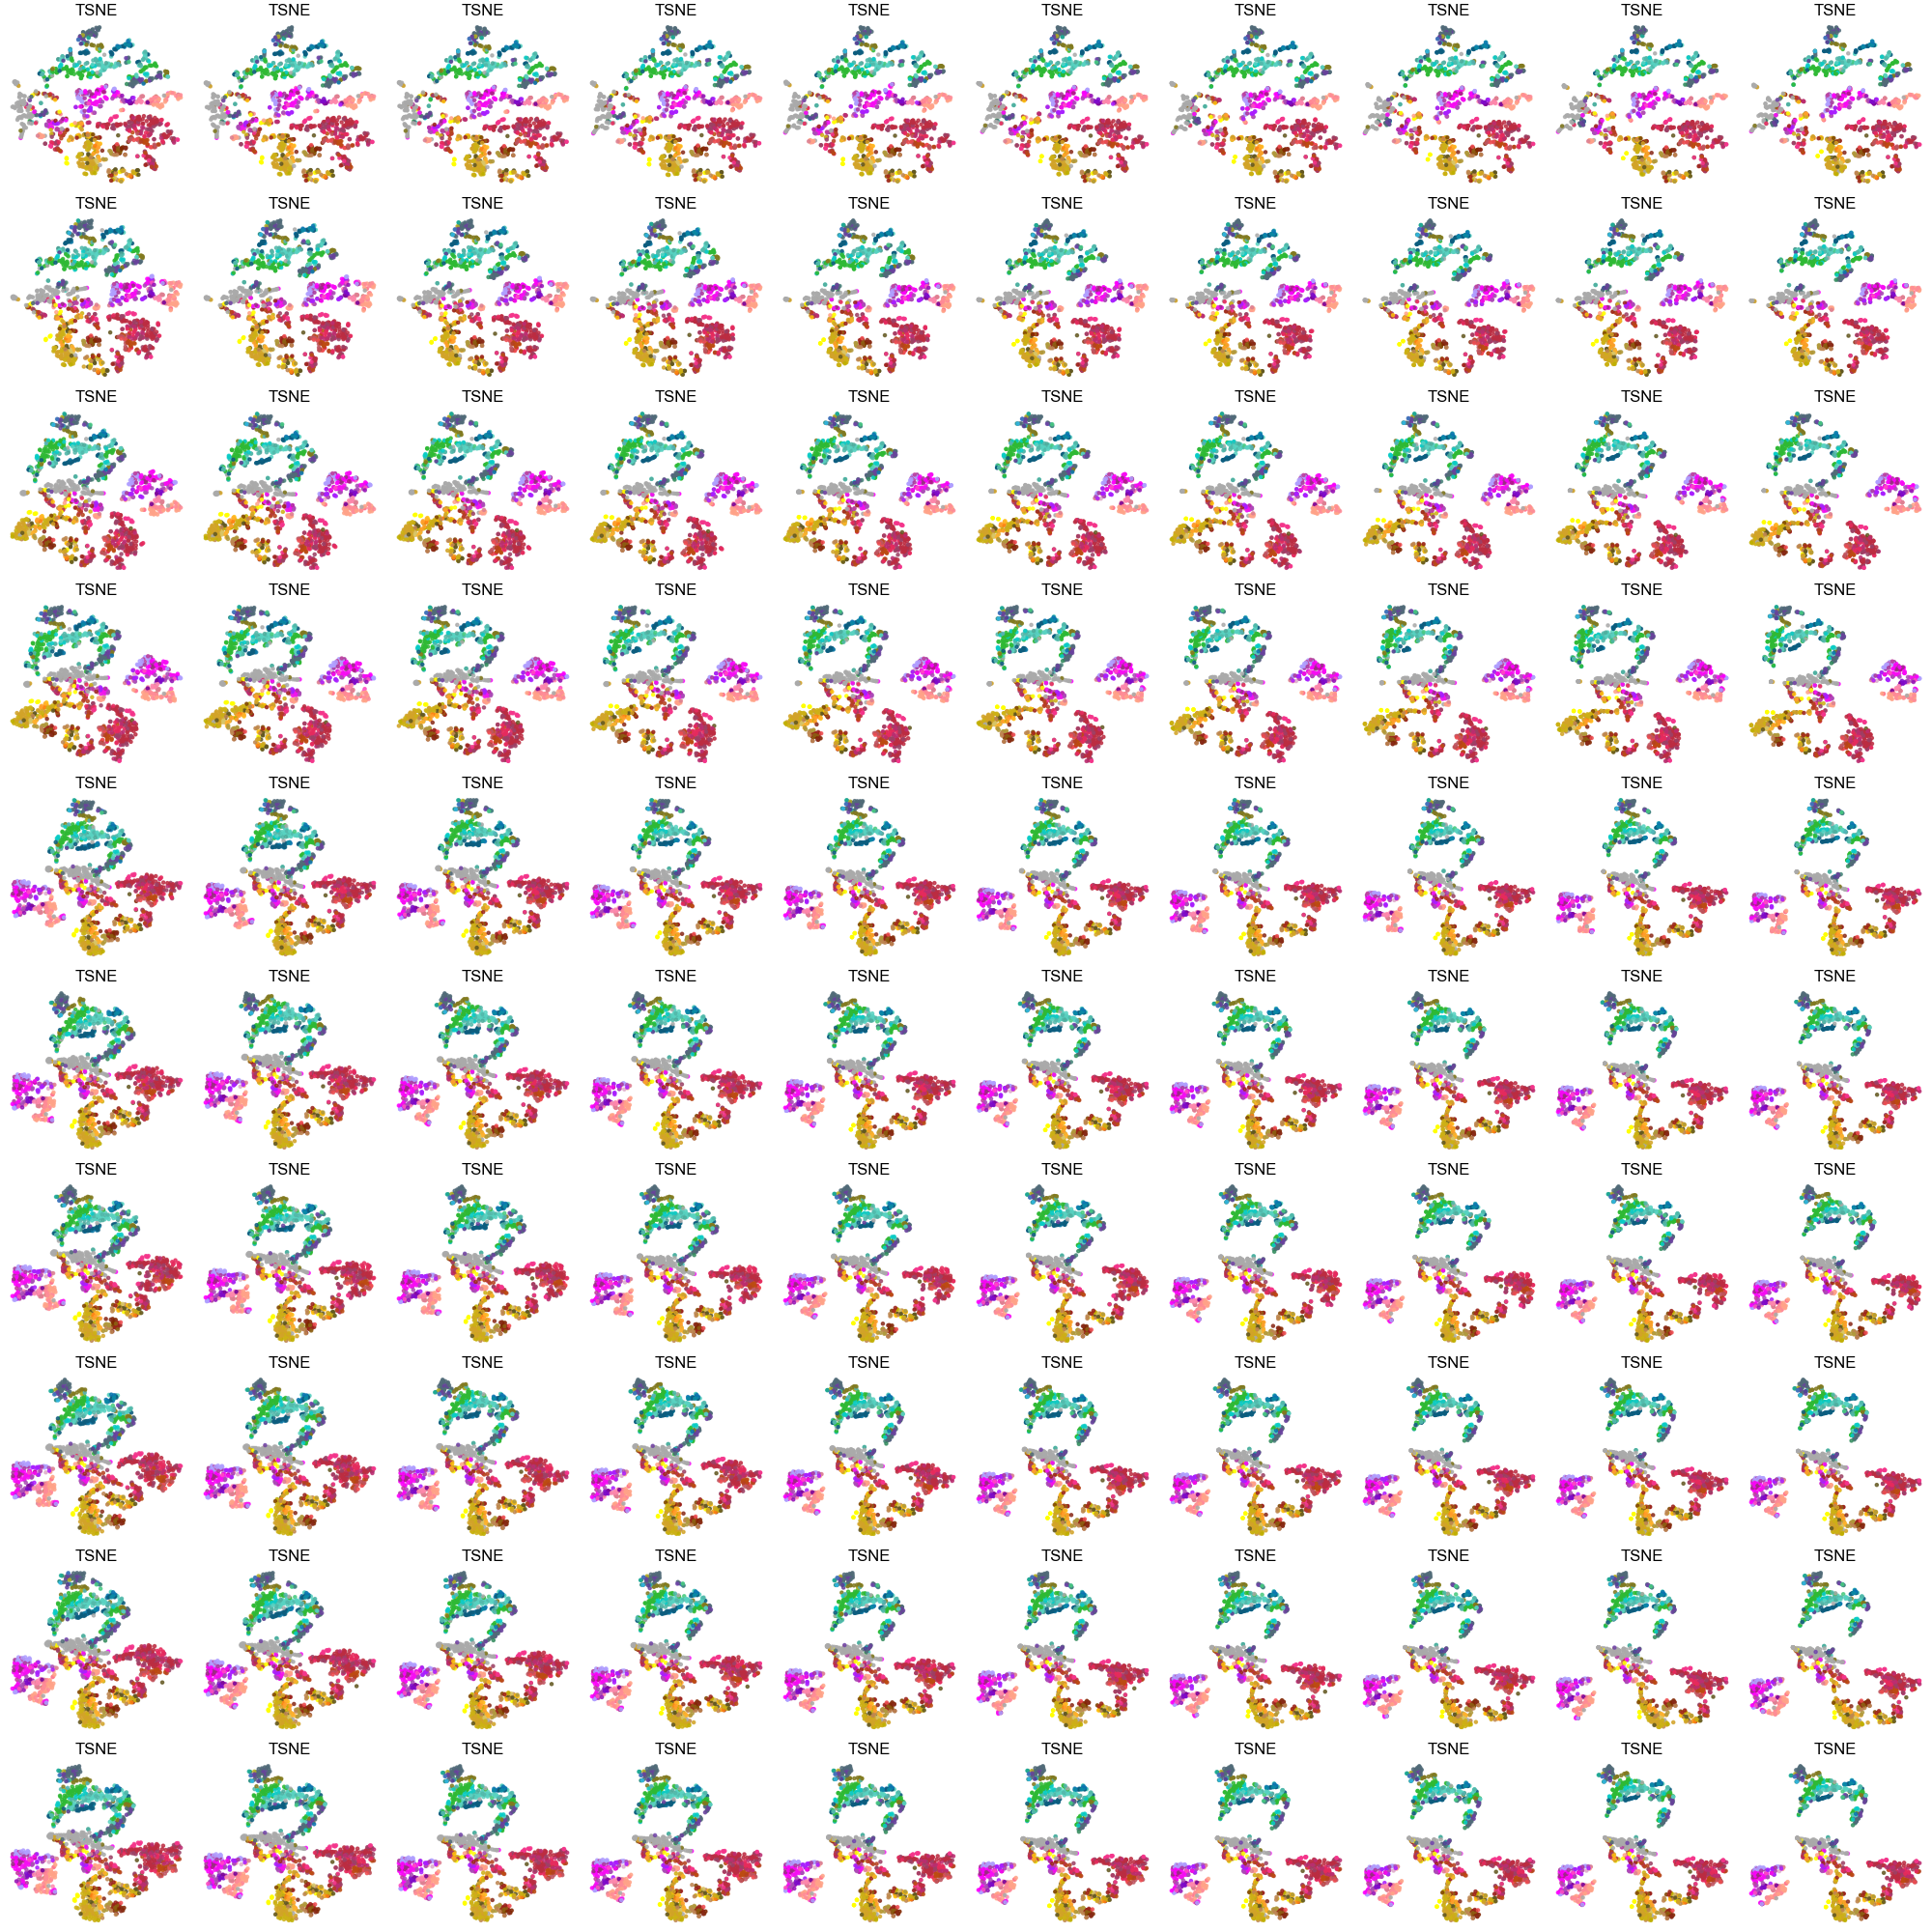

In [35]:
metrics = plot_tSNE_grid(
    np.linspace(5, 20, 10),
    np.linspace(0.9, 1.2, 10),
    pca_result,
    cluster_colors,
)

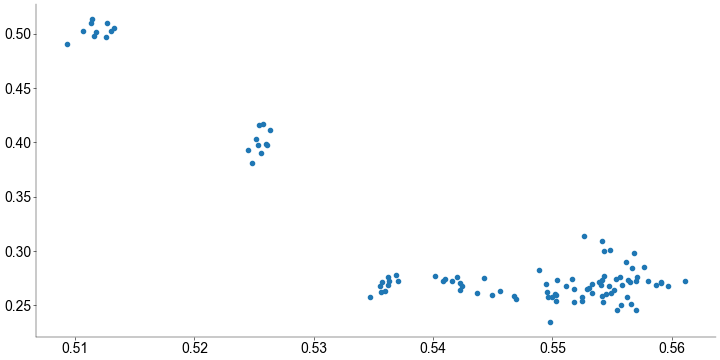

In [36]:
plt.figure()
plt.scatter([m[0] for m in metrics], [m[1] for m in metrics])